In [2]:
import copy
import pandas as pd
import pickle
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest, RFE, SelectFdr, RFECV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, regression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import plot_importance as xgb_importance
from lightgbm import plot_importance as lgb_importance
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import KFold
import itertools
import xgboost as xgb
from xgboost import DMatrix
from sklearn.model_selection import train_test_split

def evaluate(X, y_cont, y_clf, model_reg, model_clf, score):

    cv = KFold(4, shuffle=True) # custom cv
    
    print('Cross-val-score, accuracy: {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring='accuracy', cv=cv, n_jobs=8).mean()))
    print('Cross-val-score, f1_score: {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring='f1', cv=cv, n_jobs=8).mean()))
    print('Cross-val-score, precision: {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring='precision', cv=cv, n_jobs=8).mean()))
    print('Cross-val-score, recall: {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring='recall', cv=cv, n_jobs=8).mean()))
    print('Cross-val-score, roc-auc: {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring='roc_auc', cv=cv, n_jobs=8).mean()))
    
    print()
    
    model_clf.fit(X, y_clf)
    y_predicted = model_clf.predict(X)
    
    y1 = y_cont[y_predicted == 0]
    y2 = y_cont[y_predicted == 1]
    
    X1 = X[y_predicted == 0]
    X2 = X[y_predicted == 1]
    
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.7, random_state=42)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.7, random_state=42)    
    
    X_train, y_train = pd.concat((X1_train, X2_train)), pd.concat((y1_train, y2_train))
    X_test, y_test = pd.concat((X1_test, X2_test)), pd.concat((y1_test, y2_test))
    
    model_reg.fit(X_train, y_train)
    
    for sc in score:
        print(sc.__name__ + ' - исходная модель (test / train): {:.6f} / {:.6f}'.format(sc(model_reg.predict(X_test), y_test),
                                                                                      sc(model_reg.predict(X_train), y_train)))
        
        print('-' * 20)
    print()

    model_reg_inside1 = copy.copy(model_reg)
    model_reg_inside2 = copy.copy(model_reg)
    
    model_reg_inside1.fit(X1_train, y1_train)
    model_reg_inside2.fit(X2_train, y2_train)
    
    yts = np.concatenate((model_reg_inside1.predict(X1_test), model_reg_inside2.predict(X2_test)))
    ytr = np.concatenate((model_reg_inside1.predict(X1_train), model_reg_inside2.predict(X2_train)))
    
    for sc in score:
        print(sc.__name__ + ' - обработанная модель (test / train): {:.6f} / {:.6f}'.format(sc(yts, y_test), 
              sc(ytr, y_train))
             )  
        print('-' * 20)
    return model_clf, model_reg, model_reg_inside1, model_reg_inside2 

def evaluate_silently(X, y_cont, y_clf, model_reg, model_clf, score):

    cv = KFold(X.shape[0], n_folds=4, shuffle=True) # custom cv

    model_clf.fit(X, y_clf)
    y_predicted = model_clf.predict(X)
    
    y1 = y_cont[y_predicted == 0]
    y2 = y_cont[y_predicted == 1]
    
    X1 = X[y_predicted == 0]
    X2 = X[y_predicted == 1]
    
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.7, random_state=42)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.7, random_state=42)    
    
    X_train, y_train = pd.concat((X1_train, X2_train)), pd.concat((y1_train, y2_train))
    X_test, y_test = pd.concat((X1_test, X2_test)), pd.concat((y1_test, y2_test))
    
    model_reg.fit(X_train, y_train)
    
    score_reg1 = score(model_reg.predict(X_test), y_test)

    model_reg_inside1 = copy.copy(model_reg)
    model_reg_inside2 = copy.copy(model_reg)
    
    model_reg_inside1.fit(X1_train, y1_train)
    model_reg_inside2.fit(X2_train, y2_train)
    
    yts = np.concatenate((model_reg_inside1.predict(X1_test), model_reg_inside2.predict(X2_test)))
    ytr = np.concatenate((model_reg_inside1.predict(X1_train), model_reg_inside2.predict(X2_train)))
    
    score_reg2 = score(model_reg.predict(X_test), y_test)
    
    return score_reg1

def most_common(model):
    t = sorted(list(zip(model.feature_importances_, M1.columns)), reverse=True)[:20]
    td = dict([v for v in t])
    td2 = {td[k]: k for k in td}
    return td2

# y19 = pd.cut(y1, [0, 1.19, np.inf], labels=[0, 1], include_lowest=True)

def cartesian(inp):
    return list((dict(zip(inp.keys(), values)) for values in itertools.product(*inp.values())))

def prepare_arguments(lists):
    params = list(itertools.product(lists))
    d = {}
    for k, v in params:
        if k not in d:
            d[k] = []
            d[k].append(v)
        else:
            d[k].append(v)
    return d, params

def eliminate_by_one(data, target, features, model, arg={}):
    
    learned_models = []
    scores = []
    
    for feature in tqdm.tqdm(features):

        M = data.drop(columns=[feature])
        m = model(**arg)
        
        a = cross_val_score(m, M, target, scoring='r2', cv=KFold(data.shape[0], n_folds=8, shuffle=True), n_jobs=8).mean()
        b = cross_val_score(m, M, target, scoring='neg_mean_squared_error', cv=KFold(data.shape[0], n_folds=8, shuffle=True), n_jobs=8).mean()
        
        scores.append((feature, a, b))
        learned_models.append(m)
        
    return learned_models, scores

In [161]:
def daytime(x):
        if x.hour >= 12 and x.hour <= 24:
            return 'Day'
        if x.hour > 0 and x.hour < 12:
            return 'Night'

def read_data():
    d1 = pd.read_csv('./d1.csv')
    d2 = pd.read_csv('./d2.csv')
    d1 = d1.dropna()
    d2 = d2.dropna(axis=1, thresh=5000) 
    d2.rename(columns={'P17': 'Удельные потери P17'}, inplace=True)
    return d1, d2

def preprocess(d1):
    d1['Стенд/Отжиг/Поз.  ВТО'] = d1['Стенд/Отжиг/Поз.  ВТО'].fillna('')
    d1['Стенд'] = d1['Стенд/Отжиг/Поз.  ВТО'].apply(lambda x: pd.Series(x.split('/')), 1)[0]
    d1['Отжиг'] = d1['Стенд/Отжиг/Поз.  ВТО'].apply(lambda x: pd.Series(x.split('/')), 1)[1]
    d1['ВТО'] = d1['Стенд/Отжиг/Поз.  ВТО'].apply(lambda x: pd.Series(x.split('/')), 1)[2]
    d1.drop(columns=['Стенд/Отжиг/Поз.  ВТО'], inplace=True)
    l = []
    
    for col in d1.columns:
        l.append(len(pd.unique(d1[col])))
    uniqness = pd.DataFrame({'name': d1.columns, 'len': l})
    d1.drop(columns=uniqness[uniqness['len'] == 1]['name'].values, inplace=True)

    d1['Daytime1'] = d1['Дата начала обработки'].apply(lambda x: daytime(pd.to_datetime(x)), 1)
    d1['Weekday1'] = d1['Дата начала обработки'].apply(lambda x: pd.to_datetime(x).weekday(), 1)

    d1['Daytime2'] = d1['Дата обработки АТОиП-5'].apply(lambda x: daytime(pd.to_datetime(x)), 1)
    d1['Weekday2'] = d1['Дата обработки АТОиП-5'].apply(lambda x: pd.to_datetime(x).weekday(), 1)

    cat_columns = list(uniqness[uniqness['len'] <= 16]['name'].values) + \
    ['Партия АНО ПДС', '№ партии АТОиП№5', 'Дата обработки АТОиП-5', 'Дата начала обработки', 'Daytime1', 'Weekday1', 'Daytime2', 'Weekday2']
    
    y = d1['Удельные потери P17']
    X = d1.drop(columns=['Удельные потери P17'])
    
    M = pd.get_dummies(X, columns=list(set(cat_columns).intersection(set(d1.columns))))
    
    accept = []
    for c in M.columns:
        for inner in cat_columns:
            if c.startswith(inner):
                accept.append(c)
                
    accept = list(set(accept).intersection(set(M.columns)))
    
    return M, y, accept

In [162]:
d1, d2 = read_data()

X, y, cat = preprocess(d1)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [263]:
n_feature = preprocessing.scale(X).shape[1]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [238]:
from sklearn import preprocessing
X_scales = preprocessing.scale(X)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


In [259]:
f = np.random.randint(0, 5, (2, 2))
preprocessing.scale(f)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.,  1.],
       [ 0., -1.]])

In [260]:
f

array([[1, 2],
       [1, 0]])

In [249]:
i = 0
for col in X.columns:
    if col == 'Сера_0.005':
        print(i)
        i+= 1
    

0


In [244]:
X_scales[]

array([-1.30288785, -1.30288785, -1.30288785, ...,  1.95336373,
        1.95336373,  1.95336373])

In [171]:
(X[cat] > 1).iloc[0][(X[cat] > 1).iloc[0]]

Скорость технологической секции (НС 4)    True
Name: 742, dtype: bool

In [172]:
dl = 'Скорость технологической секции (НС 4)'

In [264]:
class Auto(torch.nn.Module):
    def __init__(self, n_feature, hid):
        super(Auto, self).__init__()
        self.fc_enc1 = nn.Linear(n_feature, 256)
        self.fc_enc2 = nn.Linear(256, 128)
        self.fc_enc3 = nn.Linear(128, hid)     
        
        self.fc_dec1 = nn.Linear(hid, 128)     
        self.fc_dec2 = nn.Linear(128, 256)             
        self.fc_dec3 = nn.Linear(256, n_feature)
        
        self.relu = nn.ReLU()
        self.cos = nn.CosineSimilarity()
        
    def get_hidden(self, x):
        return F.relu(self.fc_enc3(F.relu(self.fc_enc2(F.relu(self.fc_enc1(x))))))
        
        
    def forward(self, x):
        x = F.relu(self.fc_enc3(F.relu(self.fc_enc2(F.relu(self.fc_enc1(x))))))
        x = self.fc_dec3(F.relu(self.fc_dec2(F.relu(self.fc_dec1(x)))))
        return x
    
    
    def calc_loss(self, x):
        return -self.cos(self.forward(x), torch.max(x, dim=1)[0]).mean()
    
    def calc_loss2(self, x):
        return ((self.forward(x) - x) ** 2).mean()
    

In [265]:
auto = Auto(n_feature, 32)

In [266]:
BATCH = 32
EPOCH = 50

In [267]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [268]:
from sklearn.metrics.pairwise import cosine_similarity

In [269]:
auto(torch.Tensor(X_batch))[0].max()

tensor(0.1137, grad_fn=<MaxBackward1>)

In [270]:
f = torch.randn(5, 5)
torch.max(f, dim=1)[1]

tensor([2, 2, 2, 0, 1])

In [271]:
f

tensor([[ 0.5969,  0.3330,  1.0309,  0.8195,  0.1447],
        [-0.6006,  0.5680,  1.7572, -0.7133, -1.2234],
        [ 0.3850,  0.9367,  1.6925, -1.0493,  0.6238],
        [ 0.8787, -1.5626,  0.1988, -1.8939,  0.0828],
        [-0.2503,  0.9585, -0.3590,  0.4325, -0.3235]])

In [272]:
optimizer = torch.optim.Adam(auto.parameters(), lr=1e-3)
loss_epoch = []
for epoch in range(EPOCH):
    train_loss = []
    auto.train(True)

#     for X_batch, y_batch in iterate_minibatches(np.array(X[cat].drop(columns=[dl])), np.array(y), BATCH):
    for X_batch, y_batch in iterate_minibatches(preprocessing.scale(X), np.array(y), BATCH):
        loss = auto.calc_loss2(torch.Tensor(X_batch))
#         print(loss)
        train_loss.append(float(loss))

        loss.backward() 
        optimizer.step()
        optimizer.zero_grad()

    print(np.mean(train_loss[-BATCH :]))
    loss_epoch.append(np.mean(train_loss[-BATCH :]))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.04723891825415194


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.030051962239667773


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.028672616695985198


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.02278210170334205


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.015518138883635402


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.01850811598706059


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.015424710174556822


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.015144224220421165


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.019593187840655446


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.014188208733685315


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.013943892903625965


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.011154764331877232


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.017830577955464832


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.011070293345255777


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.009695510001620278


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.009917245173710398


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.009271706789149903


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.010920200540567748


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.008101690124021843


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.010087508402648382


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.008448199296253733


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.009010497044073418


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.008740750214201398


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.006975222968321759


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.010298581255483441


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.01020673145831097


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.008814695029286668


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.00866410118760541


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.00828149082371965


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.007976887689437717


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.00770218778779963


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.006310210337687749


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.0072168900951510295


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.007892864632594865


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.008980645274277776


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.0067795512222801335


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.007569252964458428


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.009470130215049721


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.006460321768827271


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.006963399500818923


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.010612220663460903


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.006535001608426683


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.006536427041282877


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.008161216188455


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.005536914752156008


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.0064394839137094095


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.007804097040207125


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.006687346562102903


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.00584212684771046


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  


0.00818162175710313


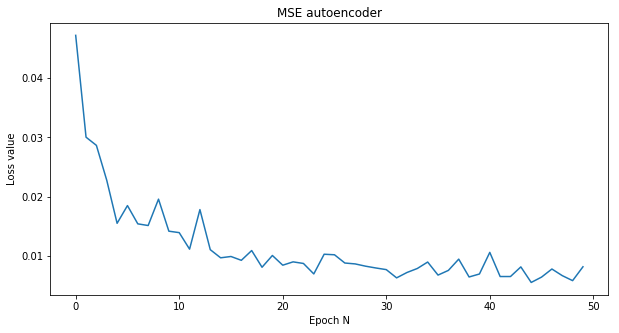

In [280]:
plt.figure(figsize=(10, 5))
plt.title('MSE autoencoder')
plt.xlabel('Epoch N')
plt.ylabel('Loss value')
plt.plot(loss_epoch)

In [283]:
auto(torch.Tensor(X_batch))[0][:10]

tensor([-1.3058, -0.5297,  0.5099,  0.4309, -0.5894, -2.0659,  0.0429, -0.5371,
        -0.5825, -0.8003], grad_fn=<SliceBackward>)

In [288]:
hidden = auto.get_hidden(torch.Tensor(preprocessing.scale(X)))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [331]:
X_train, X_val, y_train, y_val = train_test_split(np.array(hidden.detach()), 
                                                  y,
                                                  train_size=0.8,
                                                  shuffle=True)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [332]:
matr_train = DMatrix(X_train, y_train)
matr_val = DMatrix(X_val, y_val)

In [333]:
model = xgb.train(params={}, dtrain=matr_train)

[00:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[00:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[00:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[00:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[00:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[00:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[00:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[00:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[00:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, m

In [350]:
((np.abs(model.predict(matr_val) - y_val)) > 0.35).sum()

9

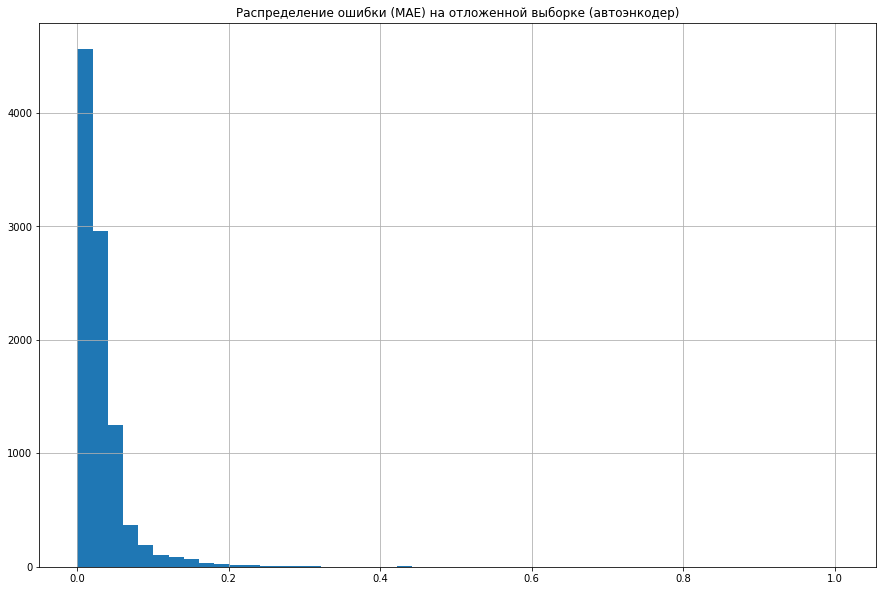

In [357]:
plt.figure(figsize=(15, 10))
plt.title('Распределение ошибки (MAE) на отложенной выборке (автоэнкодер)')
np.abs(model.predict(matr_val) - y_val).hist(bins=50)

In [335]:
Xt, Xv, yt, yv = train_test_split(X, y, train_size=0.8, shuffle=True)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [336]:
matr_t = DMatrix(Xt, yt)
matr_v = DMatrix(Xv, yv)

In [337]:
model_full = xgb.train(params={}, dtrain=matr_t)

[00:58:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[00:58:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[00:58:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[00:58:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[00:58:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[00:58:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[00:58:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[00:58:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[00:58:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes

In [351]:
(np.abs(model_full.predict(matr_v) - yv) > 0.35).sum()

2

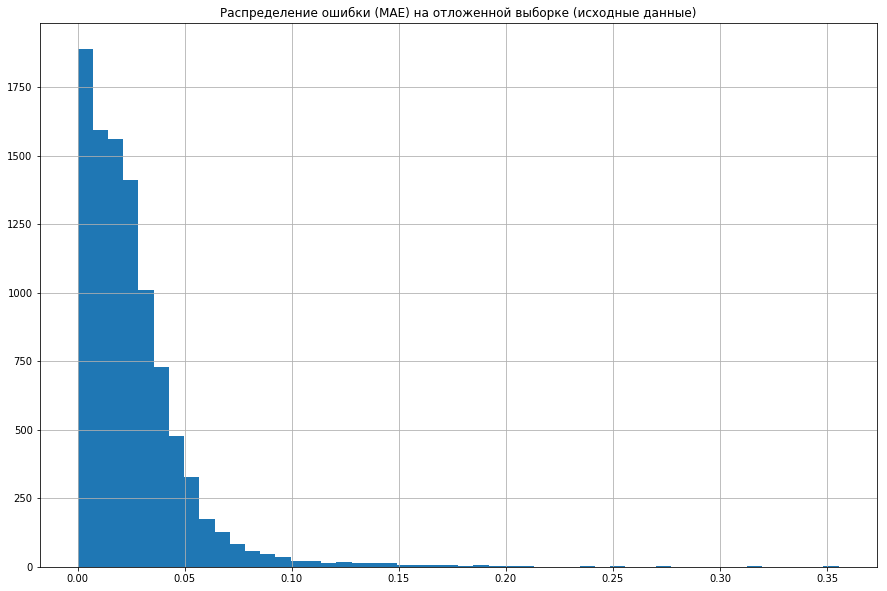

In [355]:
plt.figure(figsize=(15, 10))
plt.title('Распределение ошибки (MAE) на отложенной выборке (исходные данные)')
np.abs(model_full.predict(matr_v) - yv).hist(bins=50)